In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun May 17 18:06:00 2020

@author: kristaperks
"""

from brian2 import *
import sympy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import sys
import seaborn as sns
from scipy import signal
from scipy import optimize

import matplotlib
matplotlib.rcParams.update({'font.size': 22})

sys.path.append('/Users/kperks/mnt/engram/scripts/Python/Analysis/')
from ClassDef_AmplitudeShift_Stable import AmpShift_Stable

exptpath = Path.cwd().resolve().parents[0] #assumes running notebook from /data_processed
data_folder = exptpath / 'data_raw'

In [2]:
def calc_peaks(xtime,sweeps, order, min_peakt,threshold_h,dt):
    R = sweeps #np.mean(sweeps,1)-np.mean(sweeps,1)[0]
    
    nsamp=int(order/dt) #the window of comparison in nsamp for order; 2msec seemed good
    epsp_ = signal.argrelextrema(R,np.greater_equal,order = nsamp)[0]
    epsp_ = epsp_[np.where((epsp_*dt)>min_peakt)[0]]
    epsp = []
    measure = epsp_
    for i in measure:
        lb = int(min_peakt/dt)
        rb = len(R)-1
        min_height = np.min([abs(R[i]-R[lb]),abs(R[i]-R[rb])])
        if min_height>threshold_h:
            epsp.append(i)
    n_epsp = len(epsp)
    if len(epsp)>0:
        epsp = np.min(epsp)
    elif len(epsp)==0:
        epsp = np.NaN

    R_filt = R #signal.medfilt(R,[11]) #
    y = signal.medfilt(np.concatenate([[0],np.diff(R_filt)]),[25]) #-threshold_dvdt
    accel = signal.medfilt(np.concatenate([[0],np.diff(y)]),[11])   

    dvdt_start = int(0.002/dt)
    if ~np.isnan([epsp]).any():
        epsp_t = xtime[epsp]
        max_dvdt = np.max(y[dvdt_start:epsp])
        dvdt_threshold = 0.04#np.max([0.01,0.15*max_dvdt])

        onset_options = np.where((np.sign(y-dvdt_threshold)>0) & (np.sign(accel)>=0))[0]
        valid_onsets = onset_options[(onset_options>dvdt_start)&(onset_options<epsp)]
        if len(valid_onsets) > 0:
            if (epsp_t-(np.min(valid_onsets)*dt)) > 0: #ensure that onset is before peak
                epsp_onset_ind = np.min(valid_onsets) #min after stim artifact
                epsp_amp = R[epsp]-R[epsp_onset_ind]
                epsp_onset = xtime[epsp_onset_ind]
            elif (epsp_t-(np.min(valid_onsets)*dt)) <= 0:
                epsp_t = np.NaN
                epsp_onset = np.NaN
                epsp_amp = 0
        elif len(valid_onsets)==0:
            epsp_t = np.NaN
            epsp_onset = np.NaN
            epsp_amp = 0
    elif np.isnan([epsp]).any():
        epsp_t = np.NaN
        epsp_onset = np.NaN
        epsp_amp = 0    

    return epsp_t, epsp_amp, epsp_onset, n_epsp

def get_fsl(expt,exptname,stim_t):
    min_peakt = 0.002 #(s)
    threshold_h = 5 #(mV)
    order = 0.002 #(s)
    dt = expt.get_dt('lowgain')

    baseamp = 2.5

    sweepdur = 0.03
    basedur = 0.004

    trial_df = pd.DataFrame({})
    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',stim_t,eventDur)
    ampshift = np.asarray([np.round(((np.max(sweep)-baseamp)/baseamp)*100) for sweep in event_sweeps.T])

    trial_df.insert(np.shape(stim_df)[1],'ampshift',ampshift)

    xtime_,base = expt.get_sweepsmat('lowgain',stim_t-basedur,basedur)
    Vm = np.median(base,0)
    xtime,sweeps = expt.get_sweepsmat('lowgain',stim_t,sweepdur)
    fsl = []
    onset = []
    amp = []
    for sweep in sweeps.T:
        r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
        fsl.append(r_u[0])
        onset.append(r_u[2])
        amp.append(r_u[1])

    trial_df.insert(np.shape(stim_df)[1],'fsl',fsl)
    trial_df.insert(np.shape(stim_df)[1],'onset',onset)
    trial_df.insert(np.shape(stim_df)[1],'amp',amp)

#     u = stim_df.groupby('ampshift',sort=True)['fsl'].mean()
#     dict1 = {'exptname': exptname}
#     for k,v in zip(u.keys(),u.values):
#         dict1.update({str(k) : [v]})
#     thisdf = pd.DataFrame.from_dict(dict1)
#     thisdf = thisdf.set_index('exptname',drop=True)
#     meta_u_df = meta_u_df.append(thisdf,sort = False,ignore_index = False)

#     hfig = plt.figure(); ax = hfig.add_axes([0.1,0.1,0.8,0.8])
#     ax.scatter(ampshift,fsl)
#     ax.scatter(ampshift, onset)
#     ax.set_ylim(2,15)
#     hfig = plt.figure(); ax = hfig.add_axes([0.1,0.1,0.8,0.8])
#     ax.scatter(fsl,amp)
#     ax.set_ylim(0,45)
                                 
    return trial_df

In [4]:
def compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur):
    dt = expt.get_dt('lowgain')
    marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
    CmdTrig = expt.get_events('CmdTrig')

    min_peakt = 0.002 #(s)
    threshold_h = 20 #(mV)
    order = 0.002 #(s)
    dt = expt.get_dt('lowgain')

    #uncoupled
    bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['U'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

    trialmat = []
    for a in np.unique(trial_df['ampshift_round']):
        theseT = trial_df[trial_df['ampshift_round']==a].time.values
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        R = np.asarray([sweep-sweep[0] for sweep in R.T]).T
        R = np.asarray([signal.medfilt(sweep,35) for sweep in R.T]).T
        R_default = np.zeros(len(xtime))
        nspk = []
        for sweep in R.T:
            n,f,epsp_t = get_spikes(sweep,order,dt)
            nspk.append(n)
        nospk_inds = np.where(np.asarray(nspk) == 0)[0]
        if len(nospk_inds) > 0:
            R_default = np.mean(R[:,nospk_inds],1)
        trialmat.append(R_default)
    trialmat = np.asarray(trialmat).T
#     trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

    plt.figure(figsize=(6,5))
    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
    for i,sweep in enumerate(trialmat.T):
        plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
    plt.ylim(-2,25)

    dt = expt.get_dt('lowgain')
    Ramp_uc = np.asarray([np.max(sweep[int(0.002/dt):]) for sweep in trialmat.T])

    #coupled
    bout_df = expt.filter_marker_df_time(marker_df,bout_c)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['C'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

    trialmat = []
    for a in np.unique(trial_df['ampshift_round']):
        theseT = trial_df[trial_df['ampshift_round']==a].time.values
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        R = np.asarray([sweep-sweep[0] for sweep in R.T]).T
        R = np.asarray([signal.medfilt(sweep,35) for sweep in R.T]).T
        R_default = np.zeros(len(xtime))
        nspk = []
        for sweep in R.T:
            n,f,epsp_t = get_spikes(sweep,order,dt)
            nspk.append(n)
        nospk_inds = np.where(np.asarray(nspk) == 0)[0]
        if len(nospk_inds) > 0:
            R_default = np.mean(R[:,nospk_inds],1)
        trialmat.append(R_default)
    trialmat = np.asarray(trialmat).T
#     trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T
    
    cmd_df = expt.filter_marker_df_code(bout_df,['C'])
    cmd_t = np.asarray([CmdTrig[np.max(np.where(CmdTrig<stim_t)[0])] for stim_t in cmd_df['time'].values])
    C_latency = np.median(cmd_df.time.values-cmd_t)

    cmd_df = expt.filter_marker_df_code(bout_df,['U'])
    cmd_t = np.asarray([CmdTrig[np.max(np.where(CmdTrig<stim_t)[0])] for stim_t in cmd_df['time'].values])
    xtime,cmd_sweeps = expt.get_sweepsmat('lowgain',cmd_t+C_latency,sweepdur)
    cmd_R = np.mean(cmd_sweeps,1)-np.mean(cmd_sweeps,1)[0]

    trialmat = np.asarray([sweep-cmd_R for sweep in trialmat.T]).T

    plt.figure(figsize=(6,5))
    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
    for i,sweep in enumerate(trialmat.T):
        plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
    plt.ylim(-2,25)
#     plt.plot(xtime,cmd_R,color = 'black')

    dt = expt.get_dt('lowgain')
    Ramp_c = np.asarray([np.max(sweep[int(0.002/dt):]) for sweep in trialmat.T])

    plt.figure(figsize = (4,5))
    plt.scatter(np.unique(trial_df['ampshift_round']),Ramp_uc,color = sns.xkcd_rgb['bright green'])
    plt.scatter(np.unique(trial_df['ampshift_round']),Ramp_c,color = sns.xkcd_rgb['bright orange'])
    plt.ylim(-2,25)
    plt.xlim(-45,45)
    
    return np.unique(trial_df['ampshift_round']),Ramp_uc,Ramp_c


In [5]:
def compare_coupledJlm_uncoupled(expt,bout_c,bout_uc,sweepdur):
    t_Vm_0 = 3
    t_Vm_1 = 15
    
    marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
    CmdTrig = expt.get_events('CmdTrig')

    #uncoupled
#     bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
    bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['U'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

    trialmat = []
    for a in np.unique(trial_df['ampshift_round']):
        theseT = trial_df[trial_df['ampshift_round']==a].time.values
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

    plt.figure(figsize=(6,5))
    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
    for i,sweep in enumerate(trialmat.T):
        plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
    plt.ylim(-2,20)
#     plt.plot([t_Vm_0,t_Vm_0],[-10,10])
#     plt.plot([t_Vm_1,t_Vm_1],[-10,10])

    dt = expt.get_dt('lowgain')
    Ramp_uc = np.asarray([np.max(sweep[int(t_Vm_0/1000/dt):int(t_Vm_1/1000/dt)]) for sweep in trialmat.T])

    #coupled
#     bout_c = [expt.get_bout_win('N','Keyboard')[0],expt.get_bout_win('N','Keyboard')[1]]
    bout_df = expt.filter_marker_df_time(marker_df,bout_c)
    trial_df = expt.filter_marker_df_code(bout_df,['t'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['c'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

    trialmat = []
    for a in np.unique(trial_df['ampshift_round']):
        theseT = trial_df[trial_df['ampshift_round']==a].time.values
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T
    
    cmd_df = expt.filter_marker_df_code(bout_df,['c'])
    cmd_t = np.asarray([CmdTrig[np.max(np.where(CmdTrig<stim_t)[0])] for stim_t in cmd_df['time'].values])
    C_latency = np.median(cmd_df.time.values-cmd_t)

    cmd_df = expt.filter_marker_df_code(bout_df,['U'])
    cmd_t = np.asarray([CmdTrig[np.max(np.where(CmdTrig<stim_t)[0])] for stim_t in cmd_df['time'].values])
    xtime,cmd_sweeps = expt.get_sweepsmat('lowgain',cmd_t+C_latency,sweepdur)
    cmd_R = np.mean(cmd_sweeps,1)-np.mean(cmd_sweeps,1)[0]

#     trialmat = np.asarray([sweep-cmd_R for sweep in trialmat.T]).T

    plt.figure(figsize=(6,5))
    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
    for i,sweep in enumerate(trialmat.T):
        plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
    plt.ylim(-2,20)
#     plt.plot([t_Vm_0,t_Vm_0],[-10,10])
#     plt.plot([t_Vm_1,t_Vm_1],[-10,10])

    dt = expt.get_dt('lowgain')
    Ramp_c = np.asarray([np.max(sweep[int(t_Vm_0/1000/dt):int(t_Vm_1/1000/dt)]) for sweep in trialmat.T])

    plt.figure(figsize = (4,5))
    plt.scatter(np.unique(trial_df['ampshift_round']),Ramp_uc,color = sns.xkcd_rgb['bright green'])
    plt.scatter(np.unique(trial_df['ampshift_round']),Ramp_c,color = sns.xkcd_rgb['bright orange'])
    plt.ylim(-2,20)
    plt.xlim(-45,45)
    
    return np.unique(trial_df['ampshift_round']),Ramp_uc,Ramp_c

In [11]:
def get_spikes(xtime,sweep, order, min_peakt,threshold_h,dt):
    R = sweep
    nsamp=int(order/dt) #the window of comparison in nsamp for order; 2msec seemed good
    epsp_ = signal.argrelextrema(R,np.greater_equal,order = nsamp)[0]
    epsp_ = epsp_[np.where((epsp_*dt)>min_peakt)[0]]
    epsp = []
    measure = epsp_
    for i in measure:
        lb = int(min_peakt/dt)
        rb = len(R)-1
        min_height = np.min([abs(R[i]-R[lb]),abs(R[i]-R[rb])])
        if min_height>threshold_h:
            epsp.append(i)
    
    n_epsp = len(epsp)
    if n_epsp == 0:
        fsl = np.NaN
        epsp_t = np.NaN
    if n_epsp > 0:
        fsl = np.min(epsp)*dt*1000
        epsp_t = np.asarray(epsp)*dt*1000

    return n_epsp,fsl,epsp_t

In [7]:

def uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd):
    dt = expt.get_dt('lowgain')
    
    sweepdur = 0.05
    filtwin = int(0.003/dt)
    if filtwin % 2 == 0:
        filtwin +=1
    
    marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

    min_peakt = 0.002 #(s)
    spk_thresh = 20 #(mV)
    order = 0.0015 #(s)
    dt = expt.get_dt('lowgain')

    #######
    #uncoupled
    #######

    #get stimulus amp shift
    eventDur = 0.001
    bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
    #-SIU amp on shift trials
    trial_df = expt.filter_marker_df_code(bout_df,['T'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])
    #-SIU amp on baseline trials
    base_df = expt.filter_marker_df_code(bout_df,['U'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))
    #-calc ampshift
    ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

    #get mean response per amp shift
    trialmat = []
    for a in np.unique(trial_df['ampshift']):
        theseT = trial_df[trial_df['ampshift']==a].time.values
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        R = np.asarray([sweep-sweep[0] for sweep in R.T]).T
        R = np.asarray([signal.medfilt(sweep,filtwin) for sweep in R.T]).T
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

    plt.figure(figsize=(6,5))
    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
    for i,sweep in enumerate(trialmat.T):
        plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
    plt.ylim(-5,25)

    # get sweeps on each ampshift trial 
    xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values,sweepdur)
    sweeps = np.asarray([sweep-sweep[0] for sweep in sweeps.T]).T
    fsl = []
    onset = []
    spkamp = []
    nspk = []
    for sweep in sweeps.T:
        r_u = calc_peaks(xtime,sweep, order, min_peakt,spk_thresh,dt)
        fsl.append(r_u[0])
        onset.append(r_u[2])
        spkamp.append(r_u[1])
        n,f,epsp_t = get_spikes(xtime,sweep,order,min_peakt,spk_thresh,dt)
        nspk.append(n)
    trial_df.insert(np.shape(trial_df)[1],'fsl',fsl)
    trial_df.insert(np.shape(trial_df)[1],'onset',onset)
    trial_df.insert(np.shape(trial_df)[1],'spkamp',spkamp)
    trial_df.insert(np.shape(trial_df)[1],'nspk',nspk)
    # medfilt spikes to get psp amp
    sweeps = np.asarray([signal.medfilt(sweep,filtwin) for sweep in sweeps.T]).T
    pspamp = []
    for sweep in sweeps.T:
        pspamp.append(np.max(sweep[int(0.002/dt):])-sweep[0])
    trial_df.insert(np.shape(trial_df)[1],'pspamp',pspamp)
    trial_df.insert(np.shape(trial_df)[1],'exptname',exptname)

    trial_df_uc = trial_df

    #######
    #coupled
    #######

    #get stimulus amp shift
    eventDur = 0.001
    bout_df = expt.filter_marker_df_time(marker_df,bout_c)
    #-SIU amp on shift trials
    trial_df = expt.filter_marker_df_code(bout_df,['T'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])
    #-SIU amp on baseline trials
    base_df = expt.filter_marker_df_code(bout_df,['C'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))
    #-calc ampshift
    ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

    # get avg cmd response and mediflt
    bout_df = expt.filter_marker_df_time(marker_df,bout_cmd)
    cmd_df = expt.filter_marker_df_code(bout_df,['B'])
    xtime,sweeps = expt.get_sweepsmat('lowgain',cmd_df.time.values,sweepdur)
    # medfilt spikes
    sweeps = np.asarray([sweep-sweep[0] for sweep in sweeps.T]).T
    sweeps = np.asarray([signal.medfilt(sweep,filtwin) for sweep in sweeps.T]).T
    cmd_ = np.mean(sweeps,1)

    #get mean response per amp shift
    trialmat = []
    for a in np.unique(trial_df['ampshift']):
        theseT = trial_df[trial_df['ampshift']==a].time.values
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        R = np.asarray([sweep-sweep[0] for sweep in R.T]).T
        R = np.asarray([signal.medfilt(sweep,filtwin) for sweep in R.T]).T
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T
    trialmat = np.asarray([sweep-cmd_ for sweep in trialmat.T]).T

    plt.figure(figsize=(6,5))
    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
    for i,sweep in enumerate(trialmat.T):
        plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
    plt.ylim(-5,25)

    plt.figure(figsize=(6,3))
    plt.plot(xtime,cmd_,color = 'black')

    # get sweeps on each ampshift trial 
    xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values,sweepdur)
    sweeps = np.asarray([sweep-sweep[0] for sweep in sweeps.T]).T
    sweeps = np.asarray([sweep-cmd_ for sweep in sweeps.T]).T
    fsl = []
    onset = []
    spkamp = []
    nspk = []
    for sweep in sweeps.T:
        r_u = calc_peaks(xtime,sweep, order, min_peakt,spk_thresh,dt)
        fsl.append(r_u[0])
        onset.append(r_u[2])
        spkamp.append(r_u[1])
        n,f,epsp_t = get_spikes(xtime,sweep,order,min_peakt,spk_thresh,dt)
        nspk.append(n)
    trial_df.insert(np.shape(trial_df)[1],'fsl',fsl)
    trial_df.insert(np.shape(trial_df)[1],'onset',onset)
    trial_df.insert(np.shape(trial_df)[1],'spkamp',spkamp)
    trial_df.insert(np.shape(trial_df)[1],'nspk',nspk)
    # medfilt spikes to get psp amp
    sweeps = np.asarray([signal.medfilt(sweep,filtwin) for sweep in sweeps.T]).T
    pspamp = []
    for sweep in sweeps.T:
        pspamp.append(np.max(sweep[int(0.002/dt):])-sweep[0])
    trial_df.insert(np.shape(trial_df)[1],'pspamp',pspamp)
    trial_df.insert(np.shape(trial_df)[1],'exptname',exptname)

    trial_df_c = trial_df

    #########
    # scatter response amps
    ########

    ### normalize uncoupled
    R_ampshift_norm_uc = []

    sub_df = trial_df_uc.groupby('ampshift')
    r = sub_df.pspamp.mean().values
    normamp_uc = np.max(r)
    r = r/normamp_uc
    R_ampshift_norm_uc.append(r)

    R_ampshift_norm_uc = np.asarray(R_ampshift_norm_uc)

    ###
    R_ampshift_norm_c = []

    sub_df = trial_df_c.groupby('ampshift')
    r = sub_df.pspamp.mean().values
    r = r/normamp_uc
    R_ampshift_norm_c.append(r)

    R_ampshift_norm_c = np.asarray(R_ampshift_norm_c)

    stim_ampshift = np.unique(trial_df_c.ampshift).reshape(1,-1)

    plt.figure(figsize=(4,6))
    plt.errorbar(stim_ampshift.T,np.mean(R_ampshift_norm_uc,0),yerr=np.std(R_ampshift_norm_uc,0),linestyle="None",color = 'green')
    plt.plot(stim_ampshift,R_ampshift_norm_uc,linestyle='-',marker='o',markersize=10,color = 'green')
    plt.errorbar(stim_ampshift.T,np.mean(R_ampshift_norm_c,0),yerr=np.std(R_ampshift_norm_c,0),linestyle="None",color = 'orange')
    plt.plot(stim_ampshift,R_ampshift_norm_c,linestyle='-',marker='o',markersize=10,color = 'orange')
    plt.ylabel('peak response (%max uncoupled)')
    plt.xlabel('% stimulus amplitude shift')
    
    ### spiking
    plt.figure()
    plt.scatter(trial_df_uc.groupby('ampshift')['ampshift'].mean().values,
                trial_df_uc.groupby('ampshift')['nspk'].mean().values,
                color = 'green')
    plt.scatter(trial_df_c.groupby('ampshift')['ampshift'].mean().values,
                trial_df_c.groupby('ampshift')['nspk'].mean().values,
                color = 'orange')


In [4]:
exptpath = Path.cwd().resolve().parents[0] #assumes running notebook from /data_processed
data_folder = exptpath / 'data_raw'

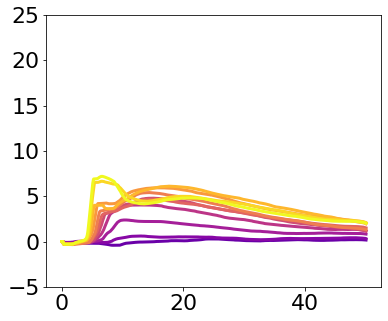

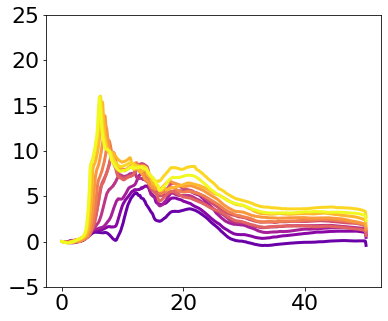

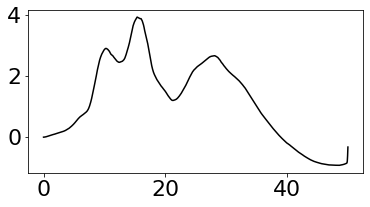

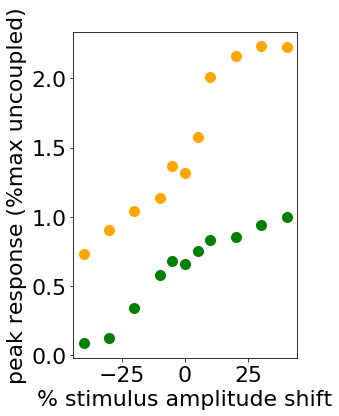

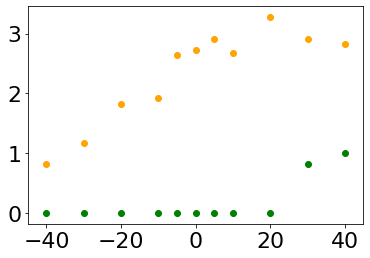

In [12]:
exptname = '20200719_005'
# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')


##### hyperpolarized to prevent as much spiking as possible
bout_uc = [expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[1]]
bout_cmd = [expt.get_bout_win('B','Keyboard')[0],
           expt.get_bout_win('B','Keyboard')[1],
           expt.get_bout_win('B','Keyboard')[2]]

uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

In [167]:
exptname = '20200712_003'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')


/Users/kperks/mnt/engram/spikedata/data_raw/20200712/20200712_003.smr


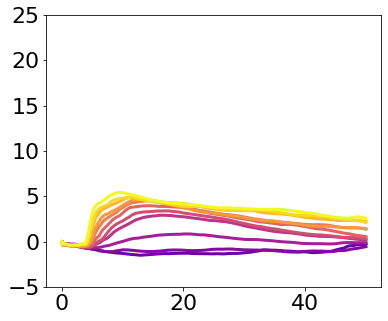

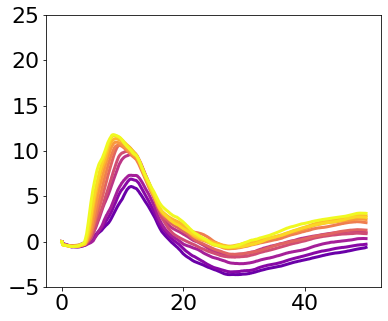

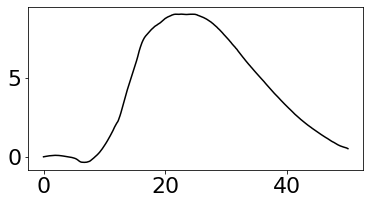

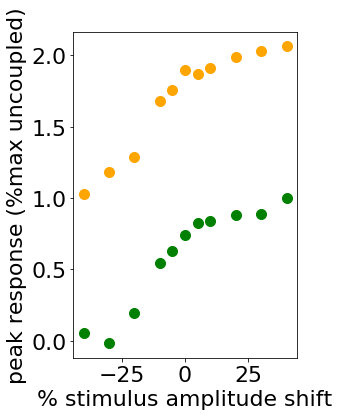

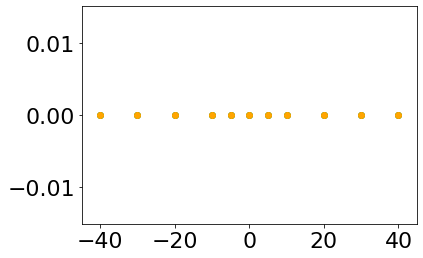

In [172]:
##### hyperpolarized to prevent as much spiking as possible
bout_uc = [expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[1],
         expt.get_bout_win('N','Keyboard')[2]]
bout_cmd = [expt.get_bout_win('B','Keyboard')[0],
           expt.get_bout_win('B','Keyboard')[1]]

uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

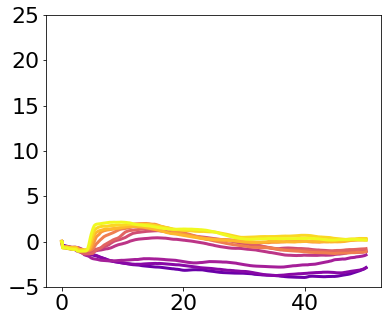

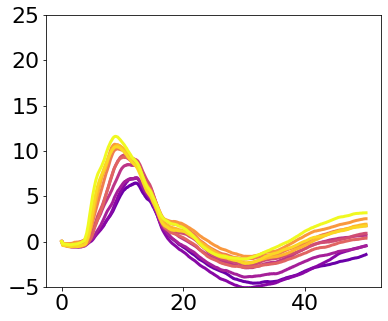

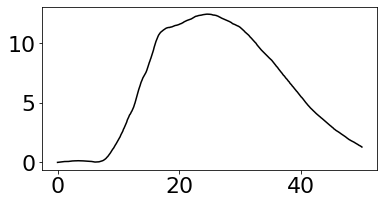

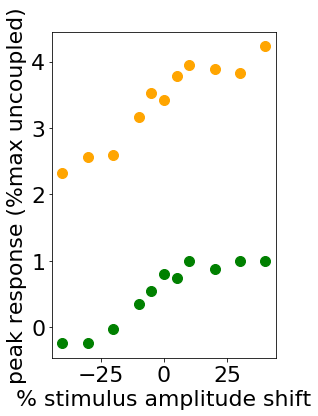

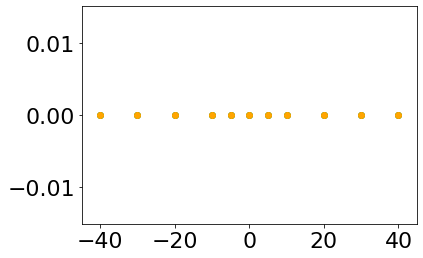

In [173]:
##### again later bout hyperpolarized to prevent as much spiking as possible
bout_uc = [expt.get_bout_win('R','Keyboard')[5]]
bout_c = [expt.get_bout_win('N','Keyboard')[5]]
bout_cmd = [expt.get_bout_win('B','Keyboard')[3]]

uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

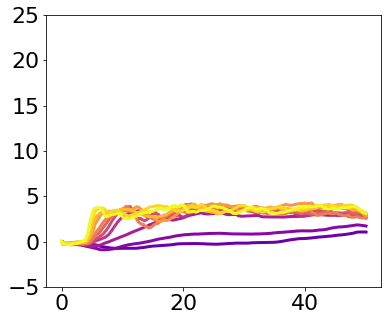

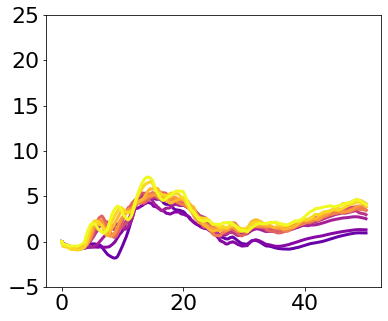

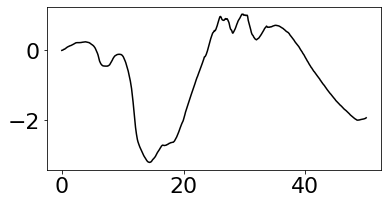

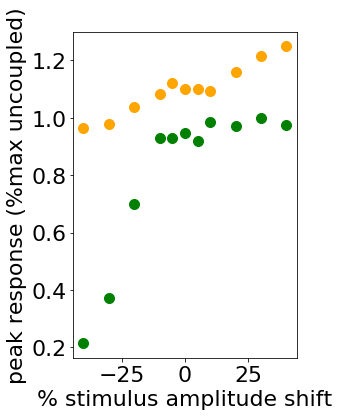

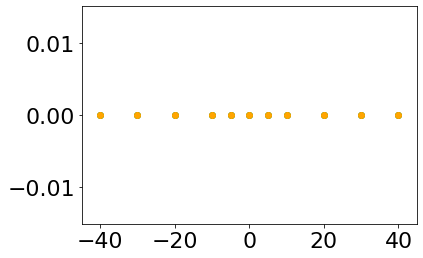

In [175]:
##### at rest
bout_uc = [expt.get_bout_win('R','Keyboard')[2],
          expt.get_bout_win('R','Keyboard')[3]]
bout_c = [expt.get_bout_win('N','Keyboard')[3]]
bout_cmd = [expt.get_bout_win('B','Keyboard')[2]]

uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

In [8]:
exptname = '20200712_000'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')


/Users/kperks/mnt/engram/spikedata/data_raw/20200712/20200712_000.smr


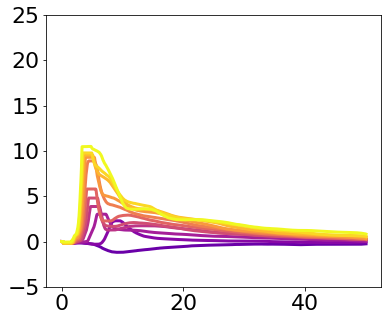

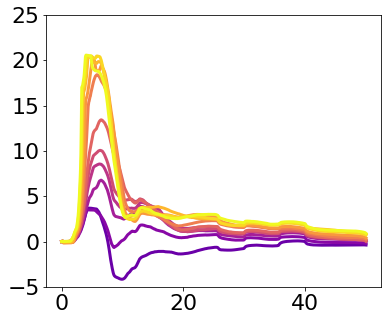

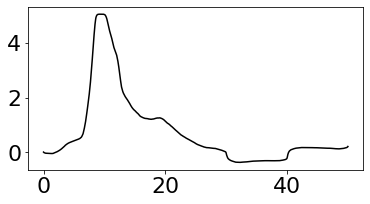

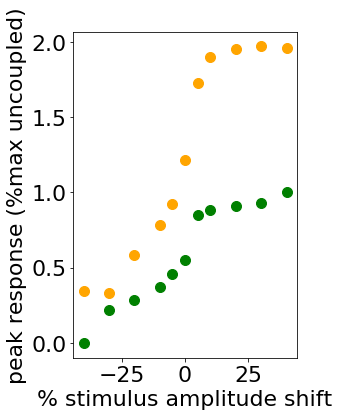

In [124]:
##### hyperpolarized to prevent as much spiking as possible
bout_uc = [expt.get_bout_win('R','Keyboard')[6]]
bout_c = [expt.get_bout_win('N','Keyboard')[5]]
bout_cmd = [expt.get_bout_win('B','Keyboard')[2],
           expt.get_bout_win('B','Keyboard')[3]]

uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

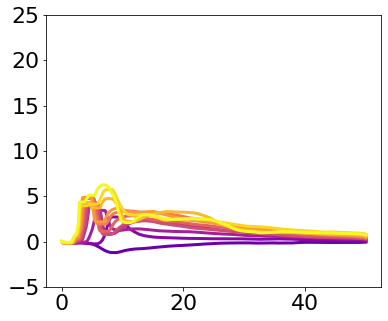

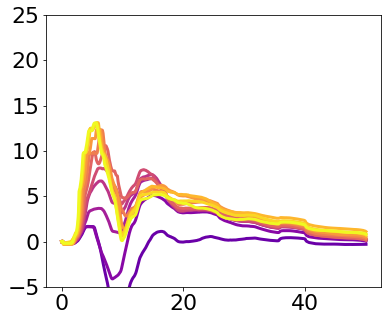

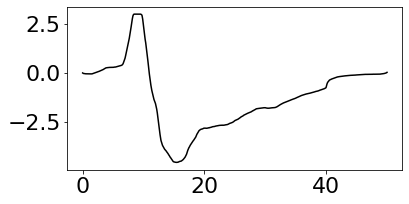

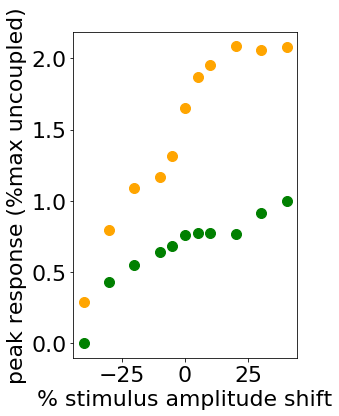

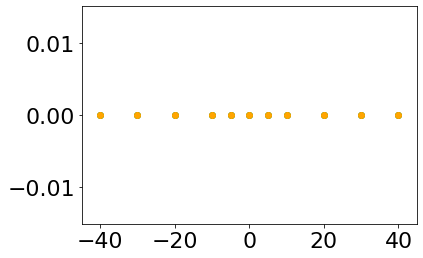

In [126]:
##### at rest for spiking
bout_uc = [expt.get_bout_win('R','Keyboard')[5]]
bout_c = [expt.get_bout_win('N','Keyboard')[4]]
bout_cmd = [expt.get_bout_win('B','Keyboard')[1]]

uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

In [128]:
exptname = '20200614_002'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

/Users/kperks/mnt/engram/spikedata/data_raw/20200614/20200614_002.smr


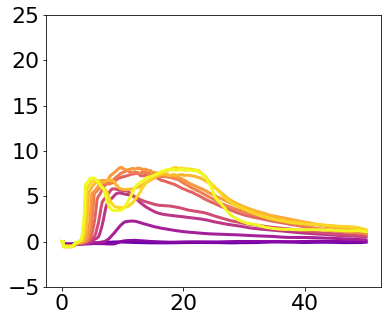

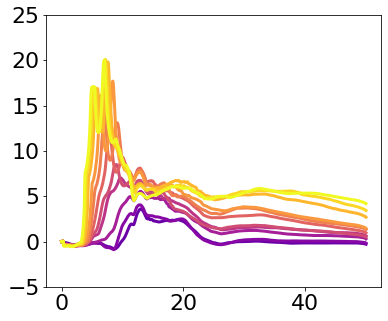

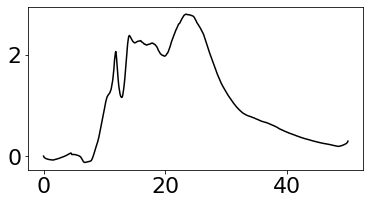

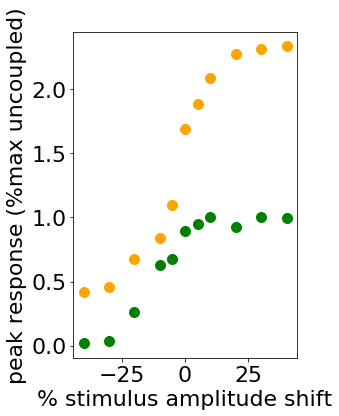

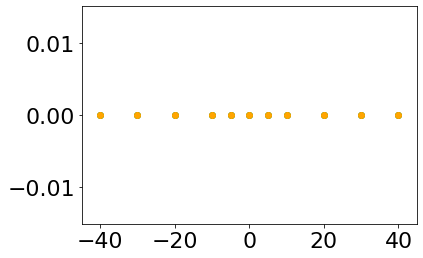

In [136]:
##### hyperpolarized
bout_uc = [expt.get_bout_win('R','Keyboard')[3],
          expt.get_bout_win('R','Keyboard')[4]]
bout_c = [expt.get_bout_win('N','Keyboard')[3],
         expt.get_bout_win('N','Keyboard')[4]]
bout_cmd = bout_uc

uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

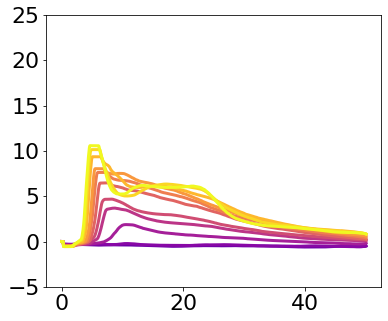

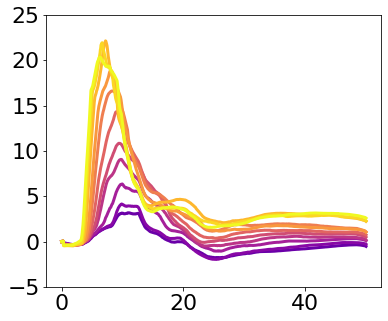

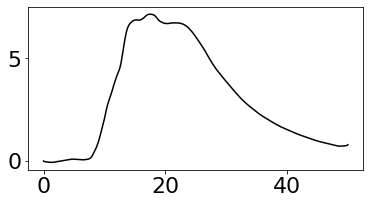

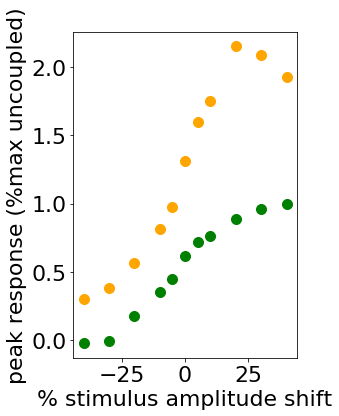

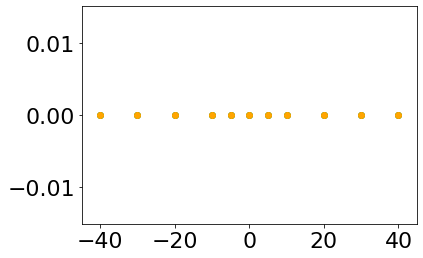

In [131]:
bout_uc = [expt.get_bout_win('R','Keyboard')[2]]
bout_c = [expt.get_bout_win('N','Keyboard')[2]]
bout_cmd = bout_uc

# amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)
uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

In [145]:
exptname = '20200122_004_ampshift'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

/Users/kperks/mnt/engram/spikedata/data_raw/20200122/20200122_004_ampshift.smr


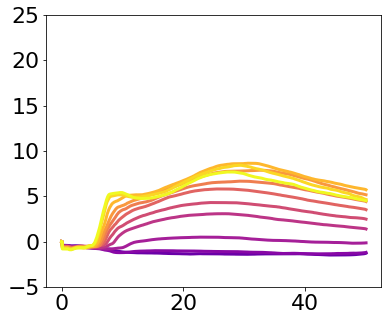

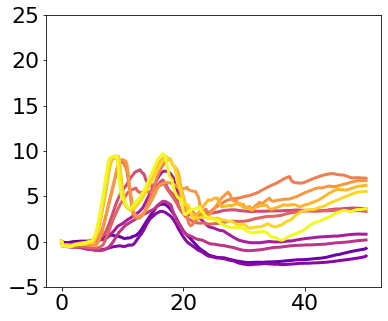

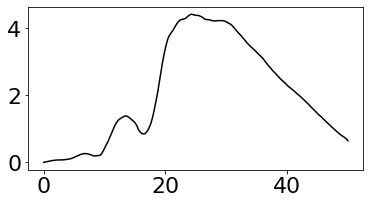

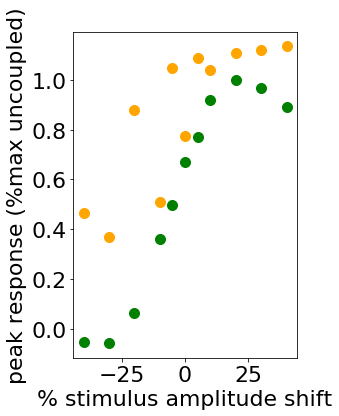

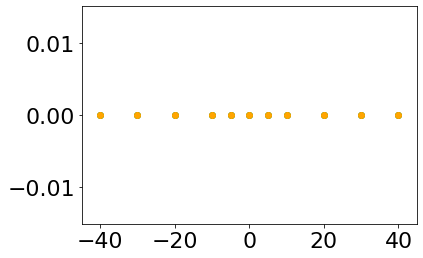

In [151]:
##### hyperpolarized
bout_uc = [expt.get_bout_win('R','Keyboard')[0],expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]
bout_cmd = [expt.get_bout_win('B','Keyboard')[0],expt.get_bout_win('B','Keyboard')[1]]

# amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)
uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

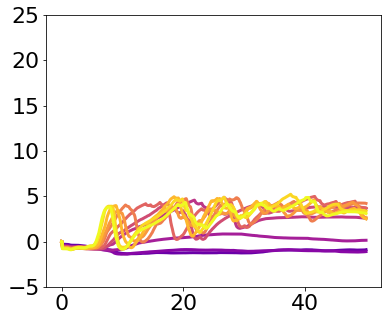

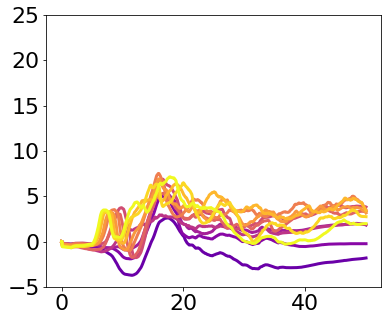

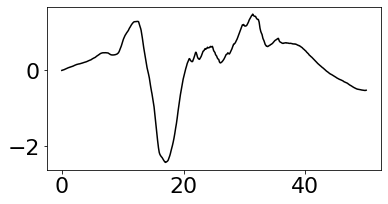

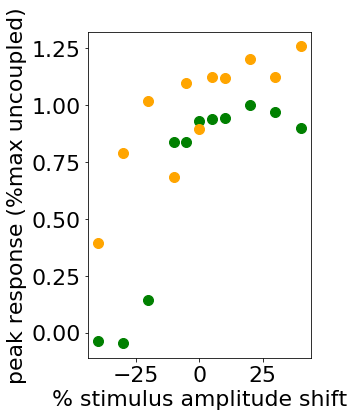

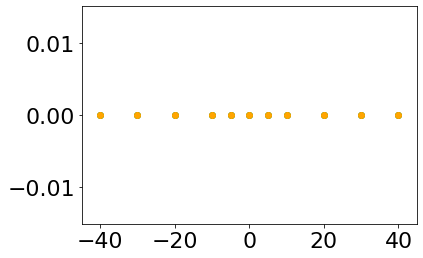

In [152]:
###### at rest
bout_uc = [expt.get_bout_win('R','Keyboard')[2]]
bout_c = [expt.get_bout_win('N','Keyboard')[1]]
bout_cmd = [expt.get_bout_win('B','Keyboard')[2]]
# amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

/Users/kperks/mnt/engram/spikedata/data_raw/20200121/20200121_001.smr


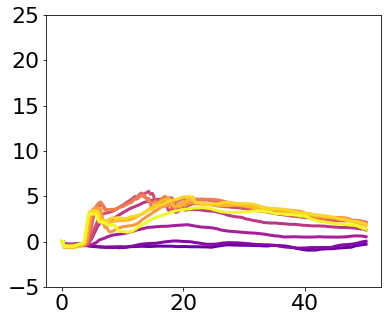

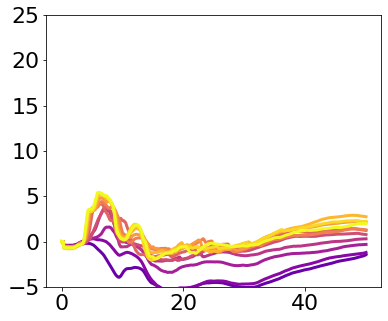

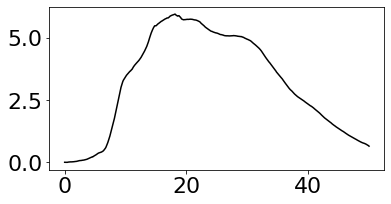

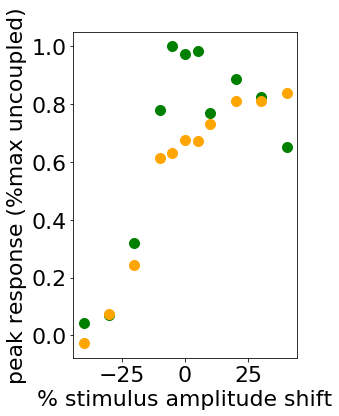

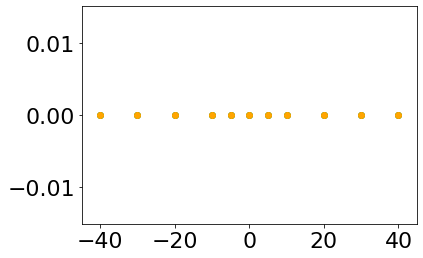

In [154]:
exptname = '20200121_001'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

###### at rest
# coupled to normal command
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

# amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)
uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

/Users/kperks/mnt/engram/spikedata/data_raw/20200121/20200121_004_ampshift.smr


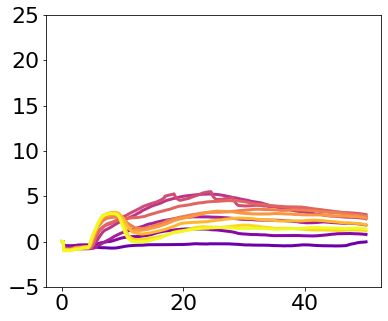

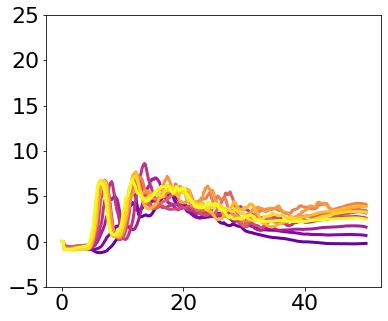

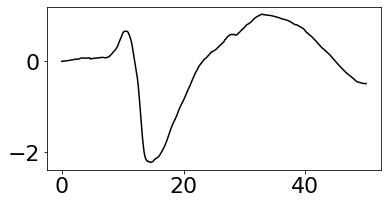

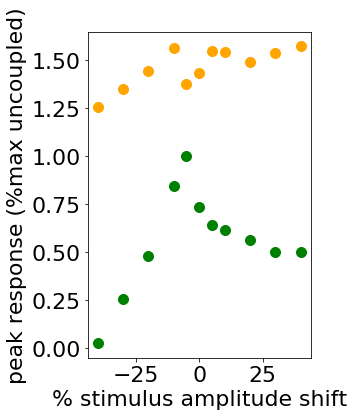

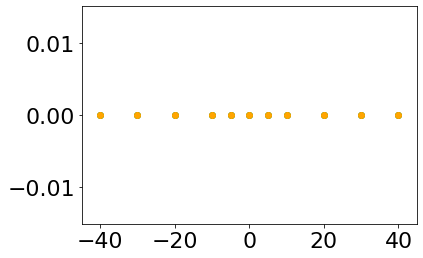

In [156]:
exptname = '20200121_004_ampshift'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

###### at rest
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]
bout_cmd = bout_uc

# amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)
uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

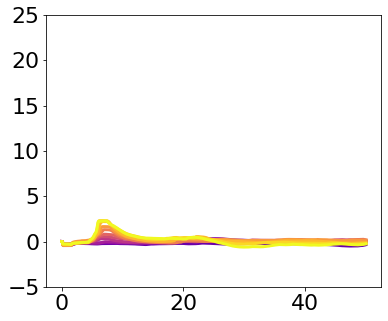

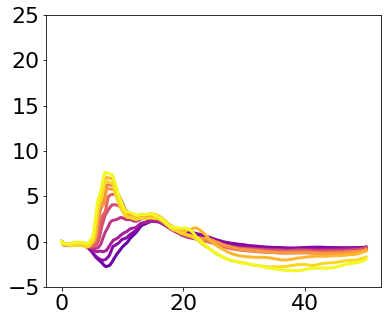

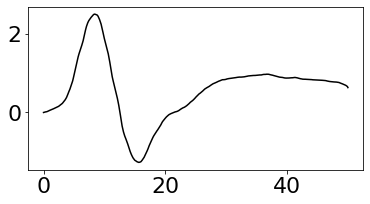

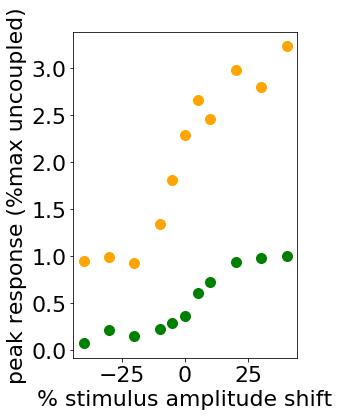

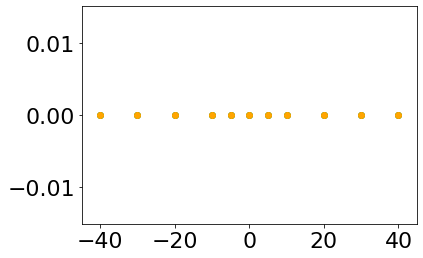

In [166]:
exptname = '20200107_004_ampshift2'
# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

##### hyperpolarized
# **** but coupled to Jlm stim not to normal command
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('K','Keyboard')[0]]
bout_cmd = [expt.get_bout_win('B','Keyboard')[0]]

# amp,Ramp_uc,Ramp_c = compare_coupledJlm_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)
uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

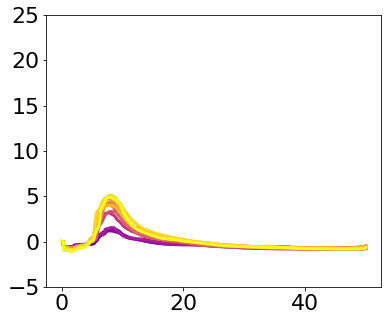

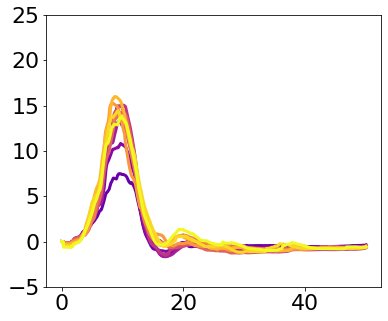

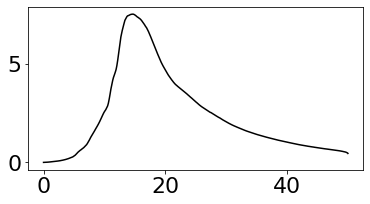

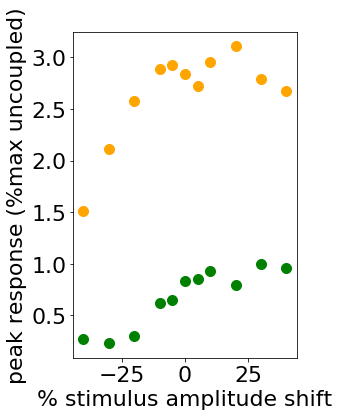

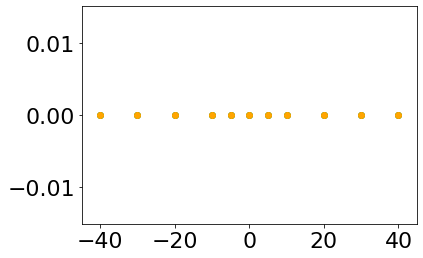

In [160]:
exptname = '20200226_003_ampshift'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

##### hyperpolarized
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]
bout_cmd = bout_uc

# amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)
uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

OLD RUNS

/Users/kperks/mnt/engram/spikedata/data_raw/20200226/20200226_003.smr


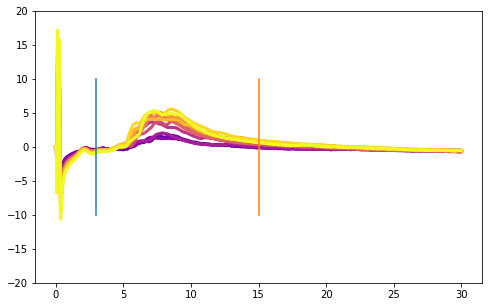

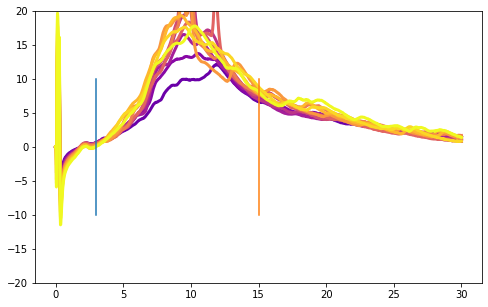

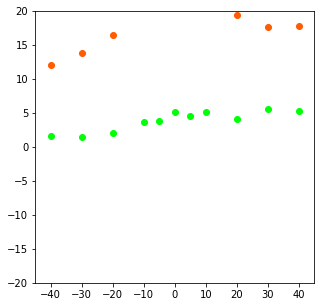

In [6]:
expt = AmpShift_Stable()
expt.load_expt('20200226_003', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

##### hyperpolarized
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

In [ ]:
exptname = '20200121_004'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

###### at rest
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

# amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)
uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

/Users/kperks/mnt/engram/spikedata/data_raw/20200122/20200122_004.smr


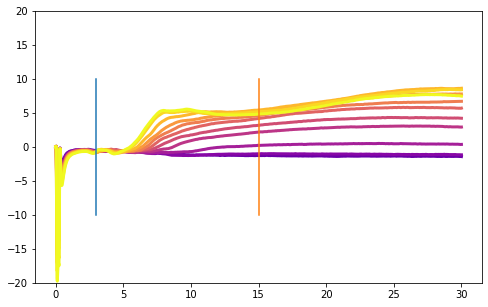

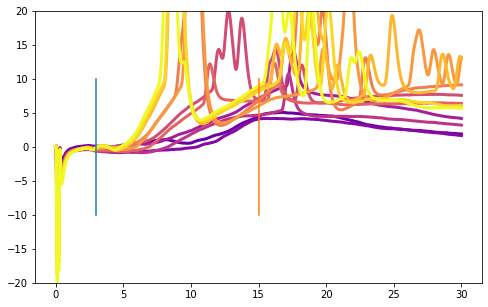

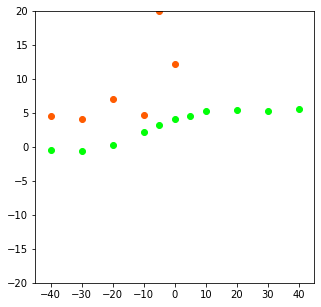

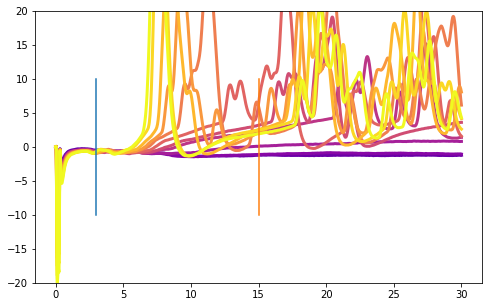

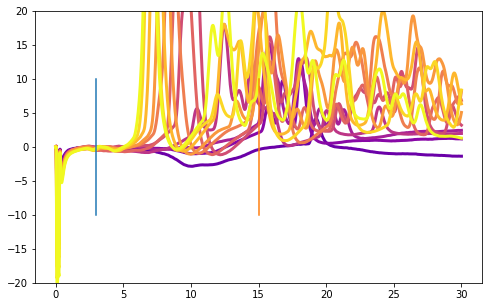

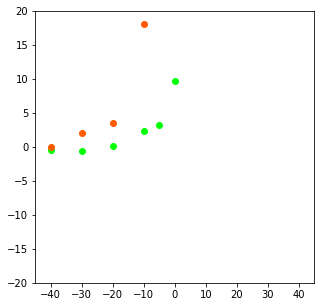

In [7]:
exptname = '20200122_004'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

##### hyperpolarized
bout_uc = [expt.get_bout_win('R','Keyboard')[0],expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

# amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)
uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

###### at rest
bout_uc = [expt.get_bout_win('R','Keyboard')[2]]
bout_c = [expt.get_bout_win('N','Keyboard')[1]]

# amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)
uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

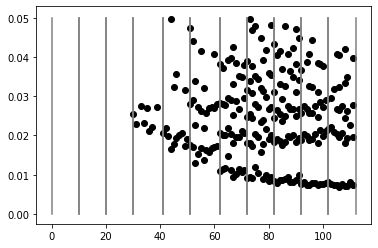

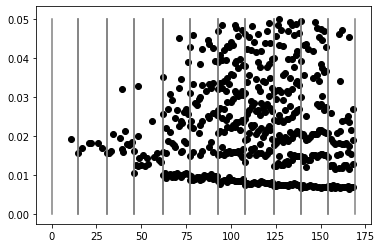

In [36]:
expt = AmpShift_Stable()
expt.load_expt('20200122_004', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

###### at rest
bout_uc = [expt.get_bout_win('R','Keyboard')[2]]
bout_c = [expt.get_bout_win('N','Keyboard')[1]]

##################

marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
CmdTrig = expt.get_events('CmdTrig')
spikes = expt.get_events('spikes')

#uncoupled
#     bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

plt.figure()
spikes_mat = []
ind = 0
for a in np.unique(trial_df['ampshift_round']):
    plt.plot([ind,ind],[0,0.05],color = 'gray')
    theseT = trial_df[trial_df['ampshift_round']==a].time.values
    for t in theseT:
        trial = spikes[((spikes>t)&(spikes<t+0.05))]-t
        spikes_mat.append(trial)
        for t in trial:
            plt.scatter(ind,t,color = 'black')
        ind = ind + 1
    plt.plot([ind,ind],[0,0.05],color = 'gray')


# Ramp_uc = np.asarray([np.max(sweep[int(t_Vm_0/1000/dt):int(t_Vm_1/1000/dt)]) for sweep in trialmat.T])

#coupled
#     bout_c = [expt.get_bout_win('N','Keyboard')[0],expt.get_bout_win('N','Keyboard')[1]]
bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['C'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

plt.figure()
spikes_mat = []
ind = 0
for a in np.unique(trial_df['ampshift_round']):
    plt.plot([ind,ind],[0,0.05],color = 'gray')
    theseT = trial_df[trial_df['ampshift_round']==a].time.values
    for t in theseT:
        trial = spikes[((spikes>t)&(spikes<t+0.05))]-t
        spikes_mat.append(trial)
        for t in trial:
            plt.scatter(ind,t,color = 'black')
        ind = ind + 1
    plt.plot([ind,ind],[0,0.05],color = 'gray')
    

# dt = expt.get_dt('lowgain')
# Ramp_c = np.asarray([np.max(sweep[int(t_Vm_0/1000/dt):int(t_Vm_1/1000/dt)]) for sweep in trialmat.T])

# plt.figure(figsize = (5,5))
# plt.scatter(np.unique(trial_df['ampshift_round']),Ramp_uc,color = sns.xkcd_rgb['bright green'])
# plt.scatter(np.unique(trial_df['ampshift_round']),Ramp_c,color = sns.xkcd_rgb['bright orange'])
# plt.ylim(-5,30)
# plt.xlim(-45,45)

# return np.unique(trial_df['ampshift_round']),Ramp_uc,Ramp_c

In [9]:
# expt = AmpShift_Stable()
# expt.load_expt('20200122_004', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

###### at rest
bout_uc = [expt.get_bout_win('R','Keyboard')[2]]
bout_c = [expt.get_bout_win('N','Keyboard')[1]]

marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

# for each stimulus amplitude, get spike response data
eventDur = 0.001
sweepdur = 0.05

bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])

xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
# ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
# trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

min_peakt = 0.002 #(s)
threshold_h = 20 #(mV)
order = 0.002 #(s)
dt = expt.get_dt('lowgain')

sweepdur = 0.03

xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values,sweepdur)
nspk = []
fsl = []
for sweep in sweeps.T:
    n,f,epsp_t = get_spikes(sweep,order, dt)
    nspk.append(n)
    fsl.append(f)

trial_df.insert(np.shape(trial_df)[1],'fsl',fsl)
trial_df.insert(np.shape(trial_df)[1],'nspk',nspk)
# meta_df = meta_df.append(trial_df,sort = False,ignore_index = False)
# amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

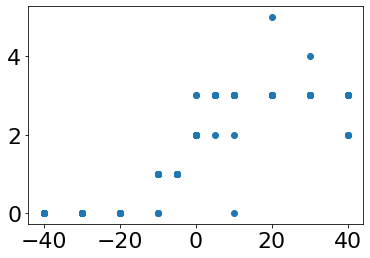

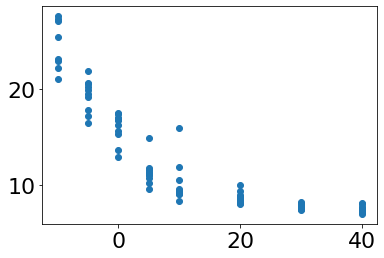

In [8]:
trial_df_u = trial_df
plt.figure()
plt.scatter(trial_df_u.ampshift,trial_df_u.nspk)
plt.figure()
plt.scatter(trial_df_u.ampshift,trial_df_u.fsl);

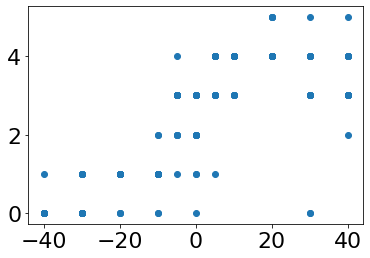

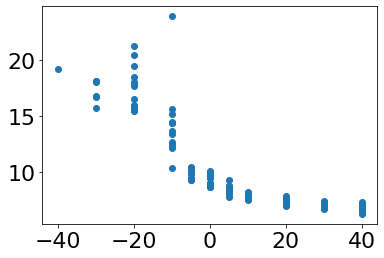

In [10]:
trial_df_c = trial_df
plt.figure()
plt.scatter(trial_df_c.ampshift,trial_df_c.nspk)
plt.figure()
plt.scatter(trial_df_c.ampshift,trial_df_c.fsl);

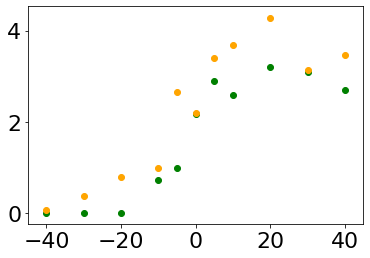

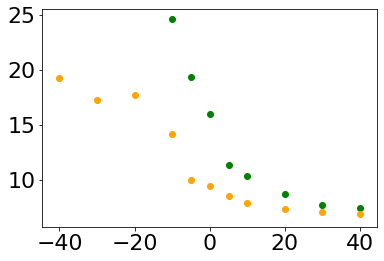

In [11]:
plt.figure()
plt.scatter(trial_df_u.groupby('ampshift')['ampshift'].mean().values,
            trial_df_u.groupby('ampshift')['nspk'].mean().values,
            color = 'green')
plt.scatter(trial_df_c.groupby('ampshift')['ampshift'].mean().values,
            trial_df_c.groupby('ampshift')['nspk'].mean().values,
            color = 'orange')

plt.figure()
plt.scatter(trial_df_u.groupby('ampshift')['ampshift'].mean().values,
            trial_df_u.groupby('ampshift')['fsl'].mean().values,
            color = 'green')
plt.scatter(trial_df_c.groupby('ampshift')['ampshift'].mean().values,
            trial_df_c.groupby('ampshift')['fsl'].mean().values,
            color = 'orange')

In [ ]:
exptname = '20200121_001'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

# ##### hyperpolarized
# bout_uc = [expt.get_bout_win('R','Keyboard')[1]]
# bout_c = [expt.get_bout_win('K','Keyboard')[1]]
# bout_cmd = bout_uc
# # amp,Ramp_uc,Ramp_c = compare_coupledJlm_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

###### at rest
# coupled to normal command
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]
bout_cmd = bout_uc

uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

/Users/kperks/mnt/engram/spikedata/data_raw/20200121/20200121_001.smr


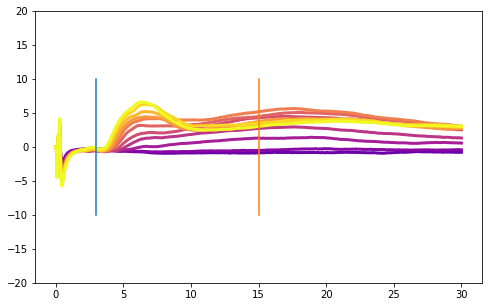

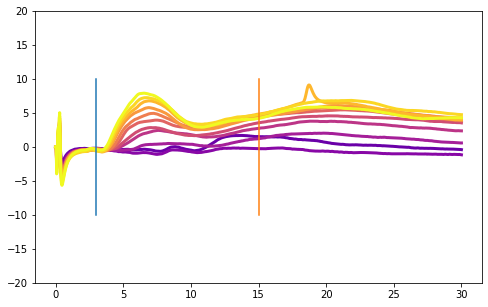

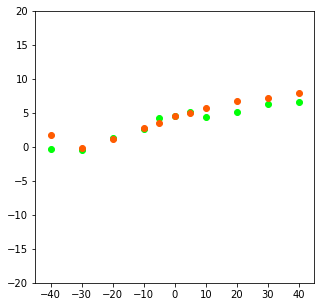

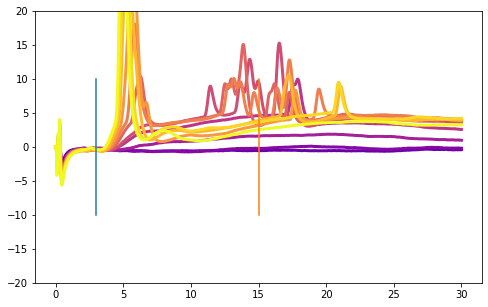

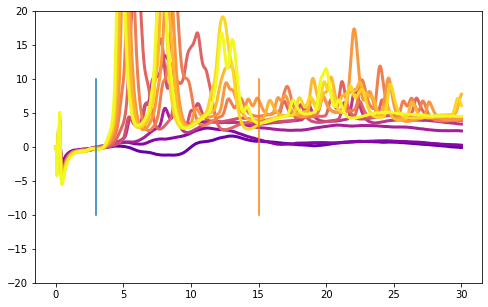

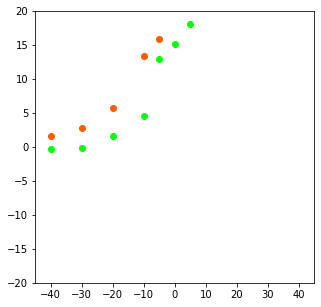

In [11]:
expt = AmpShift_Stable()
expt.load_expt('20200121_001', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

##### hyperpolarized
# **** but coupled to Jlm stim not to normal command
bout_uc = [expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('K','Keyboard')[1]]

amp,Ramp_uc,Ramp_c = compare_coupledJlm_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

###### at rest
# coupled to normal command
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

/Users/kperks/mnt/engram/spikedata/data_raw/20200121/20200121_001.smr


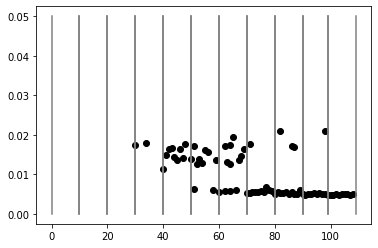

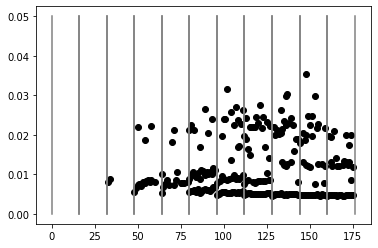

In [37]:
expt = AmpShift_Stable()
expt.load_expt('20200121_001', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

###### at rest
# coupled to normal command
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

##################

marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
CmdTrig = expt.get_events('CmdTrig')
spikes = expt.get_events('spikes')

#uncoupled
#     bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

plt.figure()
spikes_mat = []
ind = 0
for a in np.unique(trial_df['ampshift_round']):
    plt.plot([ind,ind],[0,0.05],color = 'gray')
    theseT = trial_df[trial_df['ampshift_round']==a].time.values
    for t in theseT:
        trial = spikes[((spikes>t)&(spikes<t+0.05))]-t
        spikes_mat.append(trial)
        for t in trial:
            plt.scatter(ind,t,color = 'black')
        ind = ind + 1
    plt.plot([ind,ind],[0,0.05],color = 'gray')


# Ramp_uc = np.asarray([np.max(sweep[int(t_Vm_0/1000/dt):int(t_Vm_1/1000/dt)]) for sweep in trialmat.T])

#coupled
#     bout_c = [expt.get_bout_win('N','Keyboard')[0],expt.get_bout_win('N','Keyboard')[1]]
bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['C'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

plt.figure()
spikes_mat = []
ind = 0
for a in np.unique(trial_df['ampshift_round']):
    plt.plot([ind,ind],[0,0.05],color = 'gray')
    theseT = trial_df[trial_df['ampshift_round']==a].time.values
    for t in theseT:
        trial = spikes[((spikes>t)&(spikes<t+0.05))]-t
        spikes_mat.append(trial)
        for t in trial:
            plt.scatter(ind,t,color = 'black')
        ind = ind + 1
    plt.plot([ind,ind],[0,0.05],color = 'gray')
    

# dt = expt.get_dt('lowgain')
# Ramp_c = np.asarray([np.max(sweep[int(t_Vm_0/1000/dt):int(t_Vm_1/1000/dt)]) for sweep in trialmat.T])

# plt.figure(figsize = (5,5))
# plt.scatter(np.unique(trial_df['ampshift_round']),Ramp_uc,color = sns.xkcd_rgb['bright green'])
# plt.scatter(np.unique(trial_df['ampshift_round']),Ramp_c,color = sns.xkcd_rgb['bright orange'])
# plt.ylim(-5,30)
# plt.xlim(-45,45)

# return np.unique(trial_df['ampshift_round']),Ramp_uc,Ramp_c

/Users/kperks/mnt/engram/spikedata/data_raw/20200121/20200121_004.smr


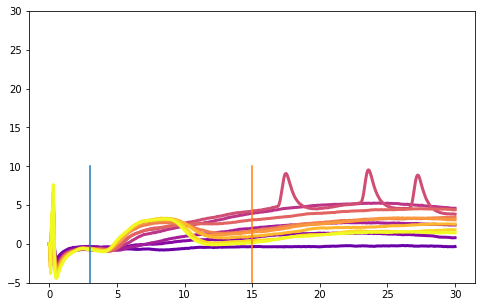

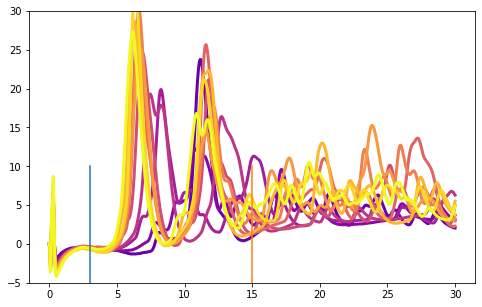

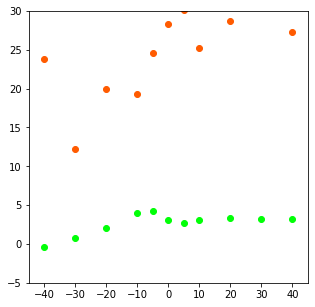

In [38]:
expt = AmpShift_Stable()
expt.load_expt('20200121_004', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

###### at rest
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

# amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)
uc_c_medfilt_spikes(expt,bout_uc,bout_c,bout_cmd)

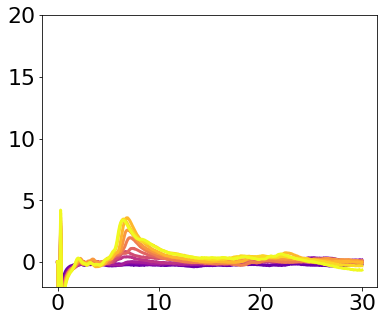

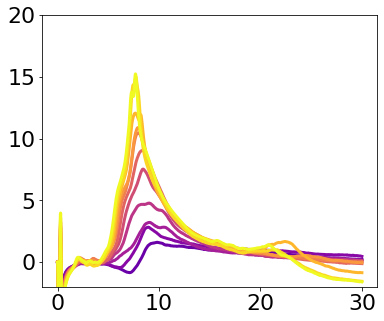

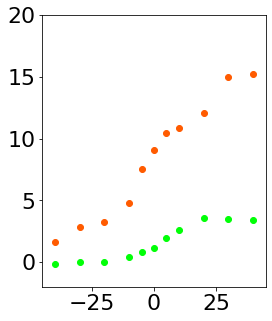

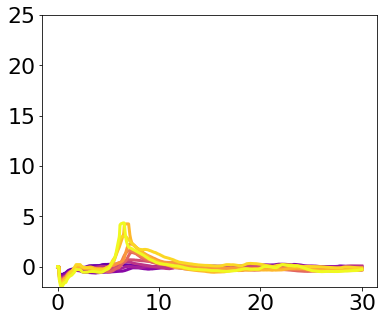

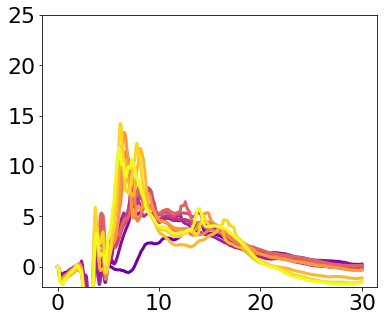

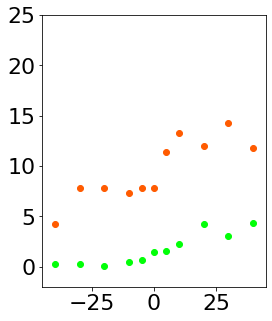

In [26]:
# expt = AmpShift_Stable()
# expt.load_expt('20200107_004', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

##### hyperpolarized
# **** but coupled to Jlm stim not to normal command
bout_uc = [expt.get_bout_win('R','Keyboard')[2]]
bout_c = [expt.get_bout_win('K','Keyboard')[2],expt.get_bout_win('K','Keyboard')[3]]

amp,Ramp_uc,Ramp_c = compare_coupledJlm_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

###### at rest
# coupled to normal command
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

/Users/kperks/mnt/engram/spikedata/data_raw/20200107/20200107_004.smr


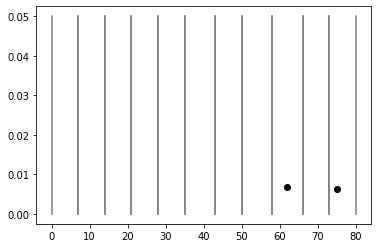

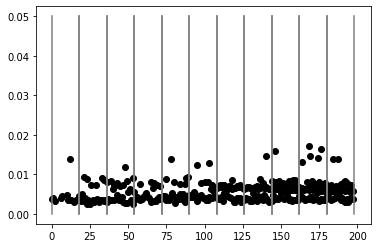

In [40]:
expt = AmpShift_Stable()
expt.load_expt('20200107_004', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

###### at rest
# coupled to normal command
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

##################

marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
CmdTrig = expt.get_events('CmdTrig')
spikes = expt.get_events('Spikes')

#uncoupled
#     bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

plt.figure()
spikes_mat = []
ind = 0
for a in np.unique(trial_df['ampshift_round']):
    plt.plot([ind,ind],[0,0.05],color = 'gray')
    theseT = trial_df[trial_df['ampshift_round']==a].time.values
    for t in theseT:
        trial = spikes[((spikes>t)&(spikes<t+0.05))]-t
        spikes_mat.append(trial)
        for t in trial:
            plt.scatter(ind,t,color = 'black')
        ind = ind + 1
    plt.plot([ind,ind],[0,0.05],color = 'gray')


# Ramp_uc = np.asarray([np.max(sweep[int(t_Vm_0/1000/dt):int(t_Vm_1/1000/dt)]) for sweep in trialmat.T])

#coupled
#     bout_c = [expt.get_bout_win('N','Keyboard')[0],expt.get_bout_win('N','Keyboard')[1]]
bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['C'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

plt.figure()
spikes_mat = []
ind = 0
for a in np.unique(trial_df['ampshift_round']):
    plt.plot([ind,ind],[0,0.05],color = 'gray')
    theseT = trial_df[trial_df['ampshift_round']==a].time.values
    for t in theseT:
        trial = spikes[((spikes>t)&(spikes<t+0.05))]-t
        spikes_mat.append(trial)
        for t in trial:
            plt.scatter(ind,t,color = 'black')
        ind = ind + 1
    plt.plot([ind,ind],[0,0.05],color = 'gray')
    
    

# dt = expt.get_dt('lowgain')
# Ramp_c = np.asarray([np.max(sweep[int(t_Vm_0/1000/dt):int(t_Vm_1/1000/dt)]) for sweep in trialmat.T])

# plt.figure(figsize = (5,5))
# plt.scatter(np.unique(trial_df['ampshift_round']),Ramp_uc,color = sns.xkcd_rgb['bright green'])
# plt.scatter(np.unique(trial_df['ampshift_round']),Ramp_c,color = sns.xkcd_rgb['bright orange'])
# plt.ylim(-5,30)
# plt.xlim(-45,45)

# return np.unique(trial_df['ampshift_round']),Ramp_uc,Ramp_c

/Users/kperks/mnt/engram/spikedata/data_raw/20191218/20191218_002.smr


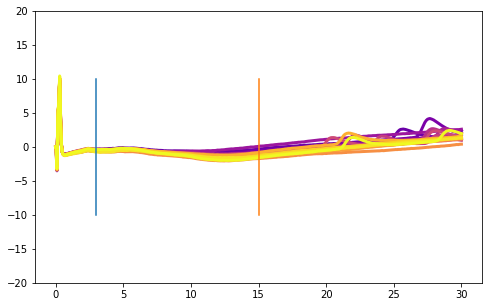

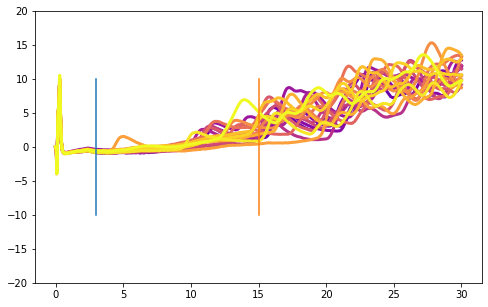

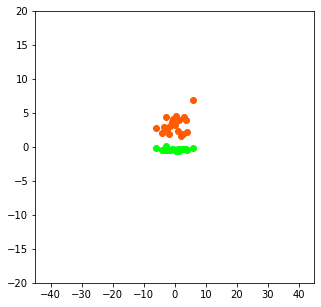

In [13]:
expt = AmpShift_Stable()
expt.load_expt('20191218_002', data_folder)

expt.set_amps(19,[-6,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4,6])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

###### at rest
bout_uc = [expt.get_bout_win('R','Keyboard')[0],expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)